### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 12th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

### Solution

In [3]:
#1) Read in hw3_data_1.npy. This is a (50 x 2) numpy array, with measurements in the first column and 
#uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, 
#compute the sample mean and the standard error on the sample mean from for this data.

import numpy as np
from scipy import optimize

data = np.load('../../../../coursework/homeworks/hw_data/hw3_data_1.npy') #reading data
m = data[:,0] #measurement
u = data[:,1] #uncertainty

samp_mean = (np.sum(m/u**2))/(np.sum(1/u**2)) #sample mean 
print('sample mean =',samp_mean)

sigma_mu = (np.sum(1/u**2))**-0.5 #standard error
print('standard error =',sigma_mu)

sample mean = 3.9179920346060557
standard error = 0.09481084100510954


SRT: Great!

In [4]:
#2) Reusing some approaches and tools from Lecture_6, write a ln-likelihood function for heteroscedastic 
#Gaussian data, and use it in a fitting algorithm to find the best-fit mean. Remember that scipy optimizers are 
#set up to minimize functions.

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize

def f(b, m, u): 
    m_fit = b #only need one constant to find fit
    return np.sum(((m - m_fit) / u) ** 2, -1) #ln likelihood


f_squared = lambda beta: f(beta, m=m, u=u) #best fit
beta0 = (1) #guess
beta_squared1 = optimize.fmin(f_squared, beta0) 
print('best fit mean =',beta_squared1)

Optimization terminated successfully.
         Current function value: 86.325091
         Iterations: 20
         Function evaluations: 40
best fit mean = [3.91796875]


SRT: Nice!

In [5]:
#3)Using the same numerical technique from Lecture_5, compute the Fisher uncertainty estimate on the mean.

xgrid = np.linspace(2,6,10)
L = []
#Ltot = []

for i in range(len(xgrid)):
    L1 = norm.pdf(m,loc=xgrid[i],scale=u)
    #print(L1)
    L.append(np.prod(L1))
    
L = np.array(L)
print(np.shape(L))


sigma_mu2 = np.diff(np.log(L), n=2)
sigma_mu2 /= (xgrid[1]-xgrid[0])**2
sigma_mu2 *= -1
sigma_mu2 = 1/np.sqrt(sigma_mu2)[0]

print("Fisher matrix error on estimated mean is %.3f" % sigma_mu2)

(10,)
Fisher matrix error on estimated mean is 0.095


In [6]:
#4) Using the bootstrap method, generate 1000 bootstrap realizations of this dataset. DO NOT use the astroML 
# code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and 
# uncertainties should stay paired together.

import random
from random import choices

## Method 1: 
# trying out randint to obtain indexes and from then obtain new arrays of m and u

newms = []
newus = []
test=[]
m = np.array(m)
u = np.array(u)

for i in range(1000):
    indexes = np.random.randint(100,size=100)
    ms = m[indexes]
    newms.append(ms)
    us = u[indexes]
    newus.append(us)

# print(np.shape(newms))
# print(np.shape(newus))

## Method 2: 
# Trying out random.choice to obtain indices and then use them to create new m and u arrays

ys = np.arange(0,100,1)
mrand = []
urand = []

for j in range(1000):
    indexes = np.random.choice(ys,size=100)
    m2 = m[indexes]
    mrand.append(m2)
    u2 = u[indexes]
    urand.append(u2)
    
# print(indexes)
# print(np.shape(mrand))

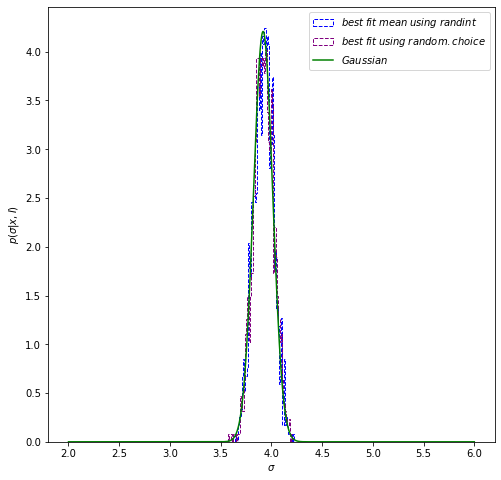

In [7]:
#5) Repeat (2) with all 1000 boostrap datasets to find the distribution of the sample mean. Plot a normalized 
#histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). 
#Do these agree?

import matplotlib.pyplot as plt
from scipy.stats import norm

## Best fits of new m's and u's from randint method (1)

best_fits1 = [] 

for i in range(1000):
    f_squared2 = lambda beta: f(beta, m=newms[i], u=newus[i]) #best fit
    beta0 = (1) #guess
    beta_squared2 = optimize.fmin(f_squared2, beta0, disp=False)
    best_fits1.append(beta_squared2[0])
    #print('best fit mean =',beta_squared)
    
#print(np.shape(best_fits))

## Best fits of new m's and u's from random.choice method (2)

best_fits2 = [] 

for j in range(1000):
    f_squared3 = lambda beta: f(beta, m=mrand[j], u=urand[j]) #best fit
    beta0 = (1) #guess
    beta_squared3 = optimize.fmin(f_squared3, beta0, disp=False)
    best_fits2.append(beta_squared3[0])
    #print('best fit mean =',beta_squared)


## Making Gaussian
xgrid = np.linspace(2,6,1000)
gaussdist = norm(samp_mean,sigma_mu)
samp_pdf = gaussdist.pdf(xgrid)

## Plotting bootstrap m's and u's from both methods as well as gaussian:
fig, ax = plt.subplots(figsize=(8, 8))

ax.hist(best_fits1, bins=50, density=True, 
        histtype='step', color='blue', ls='dashed', 
        label=r'$best \; fit \; mean \; using \; randint$')
ax.hist(best_fits2, bins=50, density=True, 
        histtype='step', color='purple', ls='dashed', 
        label=r'$best \; fit \; using \; random.choice$')
ax.plot(xgrid, samp_pdf, color='green',label=r'$Gaussian$')


#ax.set_xlim(0.82, 1.18)
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|x,I)$')
ax.legend()

plt.show()

SRT: This is awesome, Valeria! Both techniques seem to work the same, and everything agrees.

In [8]:
#6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to 
#define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace 
#location parameter 𝜇 and scale parameter Δ.

from scipy import stats
from scipy.stats import laplace

def lap(mu, delta, meas): 
    #dist = laplace.pdf(meas,mu,delta) #this didnt work on #7 but still gave us right fits on here?? why??
    dist = laplace.logpdf(meas,mu,delta)
    #return -np.prod(dist) #negative is to maximize ln L #used this line along with one commented above
    return -np.sum(dist)
    

f_lap = lambda beta: lap(beta[0], beta[1], meas=m) #best fit
beta0 = (4,1) #guess
beta_lap = optimize.fmin(f_lap, beta0) 
print('best fit mean =',beta_lap)

Optimization terminated successfully.
         Current function value: 156.788916
         Iterations: 46
         Function evaluations: 84
best fit mean = [4.08828816 0.88226923]


In [9]:
#7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is 
#favored by the data?

k1=1 #for gaussian
k2=2 #for laplace
N=100

l1 = -f(beta_squared1, m=m, u=u) #from heteroschedastic gaussian (prob 2)
print(l1)
l2 = -lap(beta_lap[0],beta_lap[1],m) #laplacian
print(l2)

aicG = -2*(l1) + 2*k1 + ((2*k1*(k1+1))/(N-k1-1))#negative f to counteract negative in function 
aicL = -2*(l2) + 2*k2 + ((2*k2*(k2+1))/(N-k2-1)) #same as above

print('Gaussian Akaike Information Criterion =',aicG)
print('Laplace Akaike Information Criterion =',aicL)

#Gaussian is better fit because value of AIC is smaller!

-86.32509075324828
-156.78891617659008
Gaussian Akaike Information Criterion = 174.69099783302715
Laplace Akaike Information Criterion = 317.7015436933863


SRT: Nicely done.

In [11]:
#8) Using the 1000 bootstrap datasets from before, fit for the Laplacian 𝜇 and Δ for each. Make a nice corner 
#plot of the distributions of 𝜇 and Δ that shows both the marginal 1D distributions and the joint 2D distribution.
#Make sure the plot has labels, shows the titles on each 1D marginal panel, and has 68% and 95% levels.

f_lap2 = lambda beta: lap(beta[0], beta[1], meas=newms) #Using laplacian function from prob 6
beta0 = (4,1) #guess
beta_lap2 = optimize.fmin(f_lap2, beta0,disp=False) 
print('best fit mean =',beta_lap2)

#I named the mu and delta arrays this way because "lap" reminded me of the stone/character of a show i like
# but also because i was blanking on names (sorry)
lapislazuli1 = [] #mu
lapislazuli2 = [] #delta

for i in range(1000):
    beta_lappie = lambda beta: lap(beta[0], beta[1], meas=newms[i]) #best fit using bootstrap m's
    beta0 = (4,1) #guess
    beta_lap2 = optimize.fmin(beta_lappie, beta0, disp=False)
    lapislazuli1.append(beta_lap2[0]) #mu arrays
    lapislazuli2.append(beta_lap2[1]) #delta arrays
    #print('best fit mean =',beta_squared)

best fit mean = [4.09244193 0.88568375]


(2, 1000)
(1000, 2)


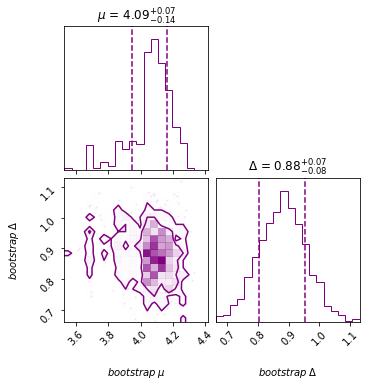

In [12]:
#8) Corner plot! So pretty!

import corner
lls = np.array([lapislazuli1, lapislazuli2])
print(np.shape(lls))
print(np.shape(lls.T))
figgie = corner.corner(lls.T,quantiles=(0.16,0.84),levels=(0.68,0.95),labels=[r'$bootstrap \; \mu$',r'$bootstrap \; \Delta$'],titles=[r'$\mu$',r'$\Delta$'],color='purple',show_titles=True)

In [16]:
#9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to 
#install numdifftools which provides a simple way to compute derivatives. We can then compute the Hessian matrix,
#which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit 
#Laplacian parameters 𝜇 and Δ. To finish, invert the matrix, and then take the square root. The diagonal entries 
#will then be the Fisher uncertainties on 𝜇 and Δ. How does these compare to the bootstrap distribution widths 
#found in (8)?

import numdifftools as nd
H = nd.Hessian(f_lap)([beta_lap[0],beta_lap[1]])
sigma_laplace = np.linalg.inv(H)**0.5

print(sigma_laplace)

print(np.std(lapislazuli1),'standard deviation of mu')
print(np.std(lapislazuli2),'standard deviation of delta')

#Standard deviation of mu and delta are similar to the values in the diagonal of the matrix as printed below

[[0.1092308  0.0071103 ]
 [0.0071103  0.08822814]]
0.1330779040183713 standard deviation of mu
0.07737243968894601 standard deviation of delta


SRT: Excellent work, Valeria! Well done.

##### as talked about in OH: np.sum() then shift tab !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

ignore please vvv

In [ ]:
# #a = [[6,3,45]],[[3,6,8,7,3,6,7,7]]
# a = ([[12,  5,  2,  4],[ 7,  6,  8,  8],[ 1,  6,  7,  7]])
# z = np.zeros(4)
# z=np.array(z)
# print(np.shape(z))
# print(type(z))
# #b = np.array([z,z,z])
# b=np.random.randint(1,size=(3,4))
# # print(np.shape(a))
# # print(type(a))
# # print(np.shape(b))
# # print(type(b))

# for i in range(3):
#     for j in range(4):
#         b[i][j] = a[i][j]

# print(a,'a')
# print(b,'b')